
 # Medical Cost Analysis — SQL-First Report

**Objective.** Identify key drivers of insurance charges using SQLite queries. Python is used only to display results, export CSVs, and produce simple charts that mirror the BI dashboard.

**Data.** `medical_cost.db` seeded from the standard insurance charges CSV. Columns: age, sex, bmi, children, smoker, region, charges.

**Outputs.** CSVs in `data/outputs/`, PNGs in `visuals/`, dashboard in `dashboard/` or `visuals/`.



## Methods
- SQL: indexing, views for BMI/age bins, group-by aggregations.
- Python: `read_sql` → preview tables; export CSVs; basic bar charts.
- BI: CSV outputs power the accompanying Power BI report.


In [42]:
import sqlite3, pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Resolve repository paths from either repo root or notebooks/
BASES = [Path.cwd(), Path.cwd().parent]
for B in BASES:
    if (B / "db" / "medical_cost.db").exists():
        DB_PATH  = B / "db"   / "medical_cost.db"
        DATA_PATH= B / "data" / "medical_cost.csv"
        VIS_DIR  = B / "visuals"; VIS_DIR.mkdir(exist_ok=True)
        OUT_DIR  = B / "data" / "outputs"; OUT_DIR.mkdir(parents=True, exist_ok=True)
        break
else:
    raise FileNotFoundError("db/medical_cost.db not found.")

conn = sqlite3.connect(DB_PATH)
TABLE_NAME = "medical_costs"

In [43]:
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = {r[0] for r in cur.fetchall()}

if TABLE_NAME not in tables:
    assert DATA_PATH.exists(), f"CSV not found: {DATA_PATH}"
    df_csv = pd.read_csv(DATA_PATH)
    df_csv.to_sql(TABLE_NAME, conn, if_exists="replace", index=False)
    print(f"Created table '{TABLE_NAME}' from {DATA_PATH.name}")
else:
    print(f"Found table '{TABLE_NAME}' in {DB_PATH.name}")


Found table 'medical_costs' in medical_cost.db


In [44]:
queries = {
    "Charges by Smoker": f"""
        SELECT smoker, ROUND(AVG(charges),2) AS avg_charges, COUNT(*) AS patients
        FROM {TABLE_NAME}
        GROUP BY smoker
        ORDER BY avg_charges DESC
    """,

    "Charges by BMI Category": f"""
        WITH t AS (
          SELECT *,
            CASE
              WHEN bmi < 18.5 THEN 'Underweight'
              WHEN bmi < 25   THEN 'Healthy'
              WHEN bmi < 30   THEN 'Overweight'
              ELSE 'Obese'
            END AS bmi_category
          FROM {TABLE_NAME}
        )
        SELECT bmi_category, ROUND(AVG(charges),2) AS avg_charges, COUNT(*) AS patients
        FROM t
        GROUP BY bmi_category
        ORDER BY CASE bmi_category
          WHEN 'Underweight' THEN 1
          WHEN 'Healthy' THEN 2
          WHEN 'Overweight' THEN 3
          ELSE 4 END
    """,

    "Charges by Age Group": f"""
        WITH t AS (
          SELECT *,
            CASE
              WHEN age < 20 THEN '0-19'
              WHEN age < 30 THEN '20-29'
              WHEN age < 40 THEN '30-39'
              WHEN age < 50 THEN '40-49'
              WHEN age < 60 THEN '50-59'
              ELSE '60-64'
            END AS age_group
          FROM {TABLE_NAME}
        )
        SELECT age_group, ROUND(AVG(charges),2) AS avg_charges, COUNT(*) AS patients
        FROM t
        GROUP BY age_group
        ORDER BY CASE age_group
          WHEN '0-19' THEN 1
          WHEN '20-29' THEN 2
          WHEN '30-39' THEN 3
          WHEN '40-49' THEN 4
          WHEN '50-59' THEN 5
          ELSE 6 END
    """,

    "Charges by Region": f"""
        SELECT region, ROUND(AVG(charges),2) AS avg_charges, COUNT(*) AS patients
        FROM {TABLE_NAME}
        GROUP BY region
        ORDER BY avg_charges DESC
    """,

    "Charges by Sex & Smoker": f"""
        SELECT sex, smoker, ROUND(AVG(charges),2) AS avg_charges, COUNT(*) AS patients
        FROM {TABLE_NAME}
        GROUP BY sex, smoker
        ORDER BY sex, smoker
    """
}



In [45]:
results = {}
for title, sql in queries.items():
    print(f"\n--- {title} ---")
    df_res = pd.read_sql_query(sql, conn)
    display(df_res.head())
    results[title] = df_res
    # export a clean snake_case CSV name
    fname = title.lower().replace(" ", "_").replace("&", "and")
    df_res.to_csv(OUT_DIR / f"{fname}.csv", index=False)

print("\nSaved outputs to:", OUT_DIR)



--- Charges by Smoker ---


,smoker,avg_charges,patients
0,yes,32050.23,274
1,no,8434.27,1064



--- Charges by BMI Category ---


,bmi_category,avg_charges,patients
0,Underweight,8852.20,20
1,Healthy,10409.34,225
2,Overweight,10987.51,386
3,Obese,15552.34,707



--- Charges by Age Group ---


,age_group,avg_charges,patients
0,0-19,8407.35,137
1,20-29,9561.75,280
2,30-39,11738.78,257
3,40-49,14399.20,279
4,50-59,16495.23,271



--- Charges by Region ---


,region,avg_charges,patients
0,southeast,14735.41,364
1,northeast,13406.38,324
2,northwest,12417.58,325
3,southwest,12346.94,325



--- Charges by Sex & Smoker ---


,sex,smoker,avg_charges,patients
0,female,no,8762.30,547
1,female,yes,30679.00,115
2,male,no,8087.20,517
3,male,yes,33042.01,159



Saved outputs to: C:\Users\bbeza\projects\hospital\data\outputs


In [46]:
def save_bar(df, x, y, title, fname, order=None, ylabel="Average Charges (USD)"):
    d = df.copy()
    if order:
        d[x] = pd.Categorical(d[x], categories=order, ordered=True)
        d = d.sort_values(x)
    ax = d.plot(kind="bar", x=x, y=y, legend=False)
    ax.set_title(title)
    ax.set_xlabel(x.replace("_"," ").title())
    ax.set_ylabel(ylabel)
    ax.figure.tight_layout()
    ax.figure.savefig(VIS_DIR / fname, dpi=160)
    plt.close(ax.figure)
    return VIS_DIR / fname

save_bar(results["Charges by Smoker"], "smoker", "avg_charges",
         "Average Charges by Smoker", "avg_charges_by_smoker.png")

save_bar(results["Charges by BMI Category"], "bmi_category", "avg_charges",
         "Average Charges by BMI Category", "avg_charges_by_bmi.png",
         order=["Underweight","Healthy","Overweight","Obese"])

save_bar(results["Charges by Age Group"], "age_group", "avg_charges",
         "Average Charges by Age Group", "avg_charges_by_age.png",
         order=["0-19","20-29","30-39","40-49","50-59","60-64"])

save_bar(results["Charges by Region"], "region", "avg_charges",
         "Average Charges by Region", "avg_charges_by_region.png")

# Sex × Smoker (simple clustered bars)
pivot = results["Charges by Sex & Smoker"].pivot(index="sex", columns="smoker", values="avg_charges").fillna(0)
ax = pivot.plot(kind="bar")
ax.set_title("Average Charges by Sex × Smoker")
ax.set_xlabel("Sex")
ax.set_ylabel("Average Charges (USD)")
ax.figure.tight_layout()
ax.figure.savefig(VIS_DIR / "avg_charges_by_sex_smoker.png", dpi=160)
plt.close(ax.figure)



In [47]:
# Pull full table for quick descriptive stats
df = pd.read_sql_query(f"SELECT * FROM {TABLE_NAME}", conn)
display(df[["age","bmi","children","charges"]].describe().T.round(2))


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.21,14.05,18.00,27.00,39.00,51.00,64.00
bmi,1338.0,30.66,6.10,15.96,26.30,30.40,34.69,53.13
children,1338.0,1.09,1.21,0.00,0.00,1.00,2.00,5.00
charges,1338.0,13270.42,12110.01,1121.87,4740.29,9382.03,16639.91,63770.43


In [48]:
conn.close()
print("Closed SQLite connection.")


Closed SQLite connection.


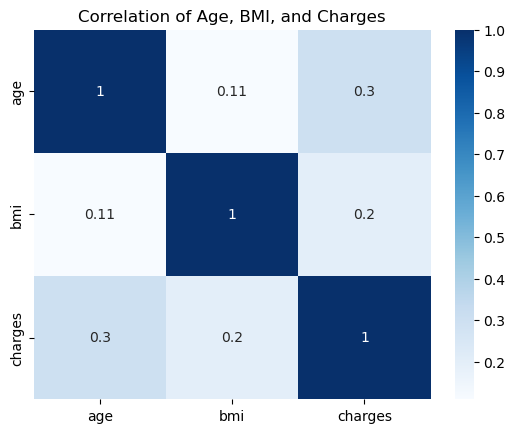

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['age','bmi','charges']].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation of Age, BMI, and Charges")
plt.show()


## Key Takeaways

- **Smokers vs Non-Smokers:** Smokers average **~$32K** compared to **~$8K** for non-smokers (~4× higher).  
- **BMI Effect:** Obese patients average **~$16K** vs **~$11K** for those with a healthy BMI.  
- **Age Effect:** Charges rise steadily with age — the **20–29 group averages ~$8K**, while the **60–64 group exceeds ~$20K**.  

**Conclusion:** Smoking status, BMI, and age are the primary cost drivers, while region and sex show comparatively smaller effects.
